<a href="https://colab.research.google.com/github/gauravraidata/IITJ-projects/blob/main/AAI_ASS1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from tqdm import tqdm

In [3]:
np.random.seed(42)

class GridWorld:
    """
    Defines the 5x5 Grid World environment.
    This class manages the game board, agent position, and rewards.
    """
    def __init__(self):
        self.size = 5
        self.agent_pos = [0, 0]
        self.goal_pos = [4, 4] # Goal state with reward +5
        self.pit_pos = [4, 0]  # Terminal state with reward -5

    def reset(self):
        """
        Resets the agent to a random starting position for a new episode.
        Ensures the agent does not start in a terminal state.
        """
        self.agent_pos = [np.random.randint(0, self.size), np.random.randint(0, self.size)]
        while list(self.agent_pos) == self.goal_pos or list(self.agent_pos) == self.pit_pos:
            self.agent_pos = [np.random.randint(0, self.size), np.random.randint(0, self.size)]
        return tuple(self.agent_pos)

    def step(self, action):
        """
        Performs an action and returns the new state, reward, and done flag.
        Actions are encoded as integers: 0=Up, 1=Down, 2=Left, 3=Right.
        """
        pos = list(self.agent_pos)
        next_pos = list(self.agent_pos)

        # Update position based on action
        if action == 0:    # Up
            next_pos[0] -= 1
        elif action == 1:  # Down
            next_pos[0] += 1
        elif action == 2:  # Left
            next_pos[1] -= 1
        elif action == 3:  # Right
            next_pos[1] += 1

        # Check for boundary collision
        if next_pos[0] < 0 or next_pos[0] >= self.size or \
           next_pos[1] < 0 or next_pos[1] >= self.size:
            return tuple(pos), -1, False # Reward -1, stay in place

        # Update the agent's position
        self.agent_pos = next_pos

        # Check for terminal states or standard moves
        if self.agent_pos == self.goal_pos:
            return tuple(self.agent_pos), 5, True   # Reward +5, episode done
        elif self.agent_pos == self.pit_pos:
            return tuple(self.agent_pos), -5, True  # Reward -5, episode done
        else:
            return tuple(self.agent_pos), 0, False  # Reward 0, continue


In [4]:
# Set a random seed for reproducibility
np.random.seed(42)

class QLearningAgent:
    """
    The agent that learns to navigate the environment using Q-Learning.
    This class manages the agent's "brain" (the Q-table) and its learning process.
    """
    def __init__(self, size, alpha, gamma, epsilon):
        self.actions = [0, 1, 2, 3] # Up, Down, Left, Right
        self.alpha = alpha     # Learning rate
        self.gamma = gamma     # Discount factor
        self.epsilon = epsilon # Exploration rate
        # The Q-table stores the expected value of taking an action in a state
        self.q_table = np.zeros((size, size, len(self.actions)))

    def choose_action(self, state):
        """
        Chooses an action using an epsilon-greedy policy.
        With probability epsilon, it explores a random action.
        Otherwise, it exploits the best-known action from the Q-table.
        """
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.actions) # Explore
        else:
            return np.argmax(self.q_table[state]) # Exploit

    def learn(self, state, action, reward, next_state, done):
        """
        Updates the Q-table using the Bellman equation for Q-Learning.
        """
        q_predict = self.q_table[state][action]
        # If the episode is done, the future value is just the final reward
        if done:
            q_target = reward
        # Otherwise, the future value is the reward + discounted max Q-value of the next state
        else:
            q_target = reward + self.gamma * np.max(self.q_table[next_state])

        # Update the Q-value for the state-action pair
        self.q_table[state][action] += self.alpha * (q_target - q_predict)

--- Running simulations for Part 1 & 2: Varying Gamma ---


Training (γ=0.9, ε=0.1): 100%|██████████| 100000/100000 [00:12<00:00, 8314.21it/s]


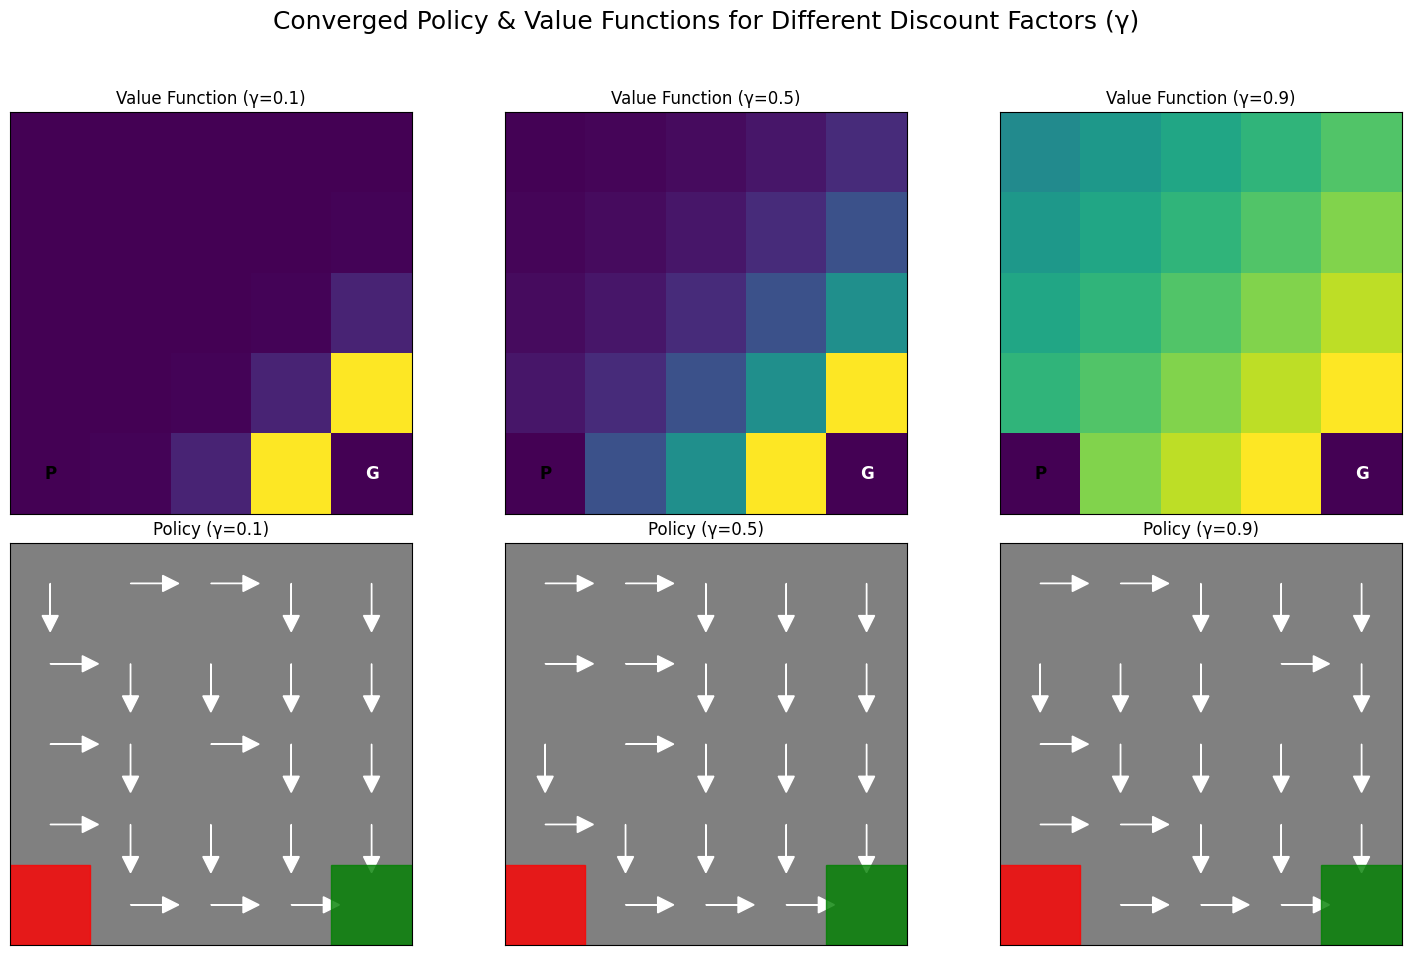


--- Running simulations for Part 3: Varying Epsilon ---


Training (γ=0.9, ε=0.5): 100%|██████████| 100000/100000 [00:12<00:00, 7776.60it/s]


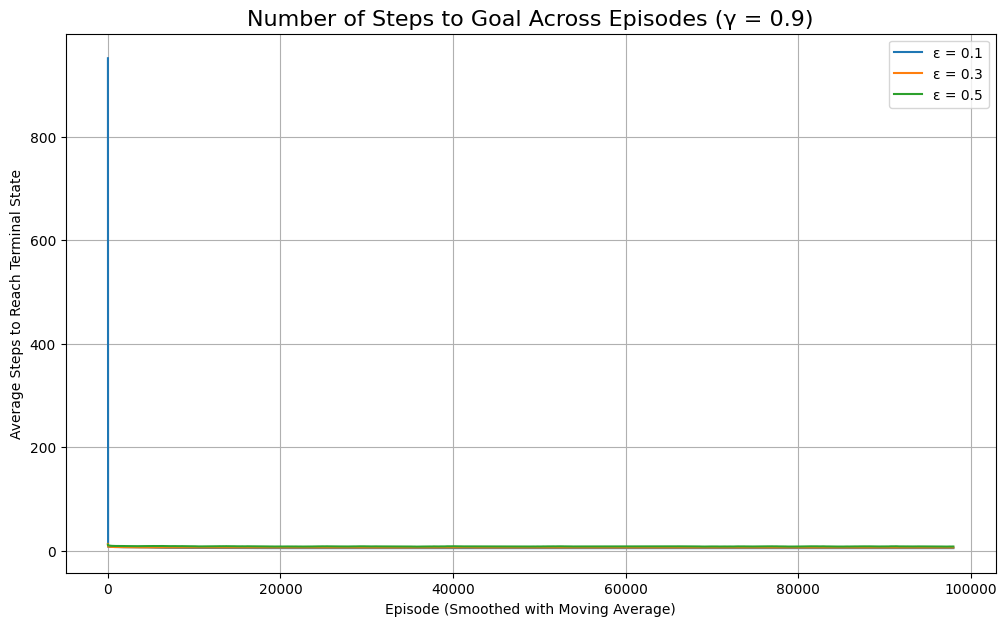

In [5]:

def plot_policy_and_value(q_table, gamma, ax_v, ax_p):
    """
    Plots the value function as a heatmap and the policy as a set of arrows.
    """
    value_function = np.max(q_table, axis=2)
    policy = np.argmax(q_table, axis=2)

    # Plot 1: Value Function Heatmap
    ax_v.imshow(value_function, cmap='viridis')
    ax_v.set_title(f'Value Function (γ={gamma})')
    ax_v.set_xticks([]), ax_v.set_yticks([])
    ax_v.text(4, 4, 'G', ha='center', va='center', color='white', weight='bold', fontsize=12)
    ax_v.text(0, 4, 'P', ha='center', va='center', color='black', weight='bold', fontsize=12)

    # Plot 2: Policy (Arrows)
    ax_p.set_title(f'Policy (γ={gamma})')
    # Create a background and overlay arrows
    ax_p.imshow(np.zeros(policy.shape), cmap='gray', vmin=-1, vmax=1)

    # Define mapping from action index to (dy, dx) arrow vector
    action_map = {0: (-1, 0), 1: (1, 0), 2: (0, -1), 3: (0, 1)} # (row_change, col_change)
    for r in range(policy.shape[0]):
        for c in range(policy.shape[1]):
            if (r, c) != (4, 4) and (r, c) != (4, 0): # No arrows on terminal states
                dy, dx = action_map[policy[r, c]]
                # Plot an arrow in the middle of the cell
                if dx != 0 or dy != 0:
                    ax_p.arrow(c, r, dx*0.4, dy*0.4, head_width=0.2, head_length=0.2, fc='white', ec='white')

    # Mark Goal (G) and Pit (P) with colored squares for clarity
    goal_patch = mpatches.Rectangle((3.5, 3.5), 1, 1, color='green', alpha=0.8)
    pit_patch = mpatches.Rectangle((-0.5, 3.5), 1, 1, color='red', alpha=0.8)
    ax_p.add_patch(goal_patch)
    ax_p.add_patch(pit_patch)
    ax_p.set_xticks([]), ax_p.set_yticks([])
    ax_p.set_ylim(4.5, -0.5) # Invert y-axis to match matrix indexing
    ax_p.set_xlim(-0.5, 4.5)

# --- Main Simulation Logic ---

def run_simulation(env, agent, episodes):
    """
    Runs the main training loop for a specified number of episodes.
    Returns a list of the number of steps taken in each episode.
    """
    steps_per_episode = []
    # Use tqdm for a progress bar during training
    for _ in tqdm(range(episodes), desc=f"Training (γ={agent.gamma}, ε={agent.epsilon})"):
        state = env.reset()
        done = False
        steps = 0
        while not done:
            action = agent.choose_action(state)
            next_state, reward, done = env.step(action)
            agent.learn(state, action, reward, next_state, done)
            state = next_state
            steps += 1
        steps_per_episode.append(steps)
    return steps_per_episode

# --- Part 1 & 2: Varying Gamma (Discount Factor) ---
print("--- Running simulations for Part 1 & 2: Varying Gamma ---")
gamma_values = [0.1, 0.5, 0.9]
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Converged Policy & Value Functions for Different Discount Factors (γ)', fontsize=18)

for i, gamma in enumerate(gamma_values):
    env = GridWorld()
    # Epsilon = 0.1 and Alpha = 0.1 as specified
    agent = QLearningAgent(size=5, alpha=0.1, gamma=gamma, epsilon=0.1)
    run_simulation(env, agent, episodes=100000)
    plot_policy_and_value(agent.q_table, gamma, axes[0, i], axes[1, i])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# --- Part 3: Varying Epsilon (Exploration Rate) ---
print("\n--- Running simulations for Part 3: Varying Epsilon ---")
epsilon_values = [0.1, 0.3, 0.5]
gamma_fixed = 0.9 # Gamma = 0.9 as specified
plt.figure(figsize=(12, 7))

for epsilon in epsilon_values:
    env = GridWorld()
    # Alpha = 0.1 as specified
    agent = QLearningAgent(size=5, alpha=0.1, gamma=gamma_fixed, epsilon=epsilon)
    steps_data = run_simulation(env, agent, episodes=100000)

    # Smooth the noisy step data with a moving average to see the learning trend
    window_size = 2000
    moving_avg = np.convolve(steps_data, np.ones(window_size)/window_size, mode='valid')
    plt.plot(moving_avg, label=f'ε = {epsilon}')

plt.title(f'Number of Steps to Goal Across Episodes (γ = {gamma_fixed})', fontsize=16)
plt.xlabel('Episode (Smoothed with Moving Average)')
plt.ylabel('Average Steps to Reach Terminal State')
plt.legend()
plt.grid(True)
plt.show()

--- Running simulations for Part 1 & 2: Varying Gamma ---


Training (γ=0.9, ε=0.1): 100%|██████████| 100000/100000 [00:12<00:00, 8051.68it/s]


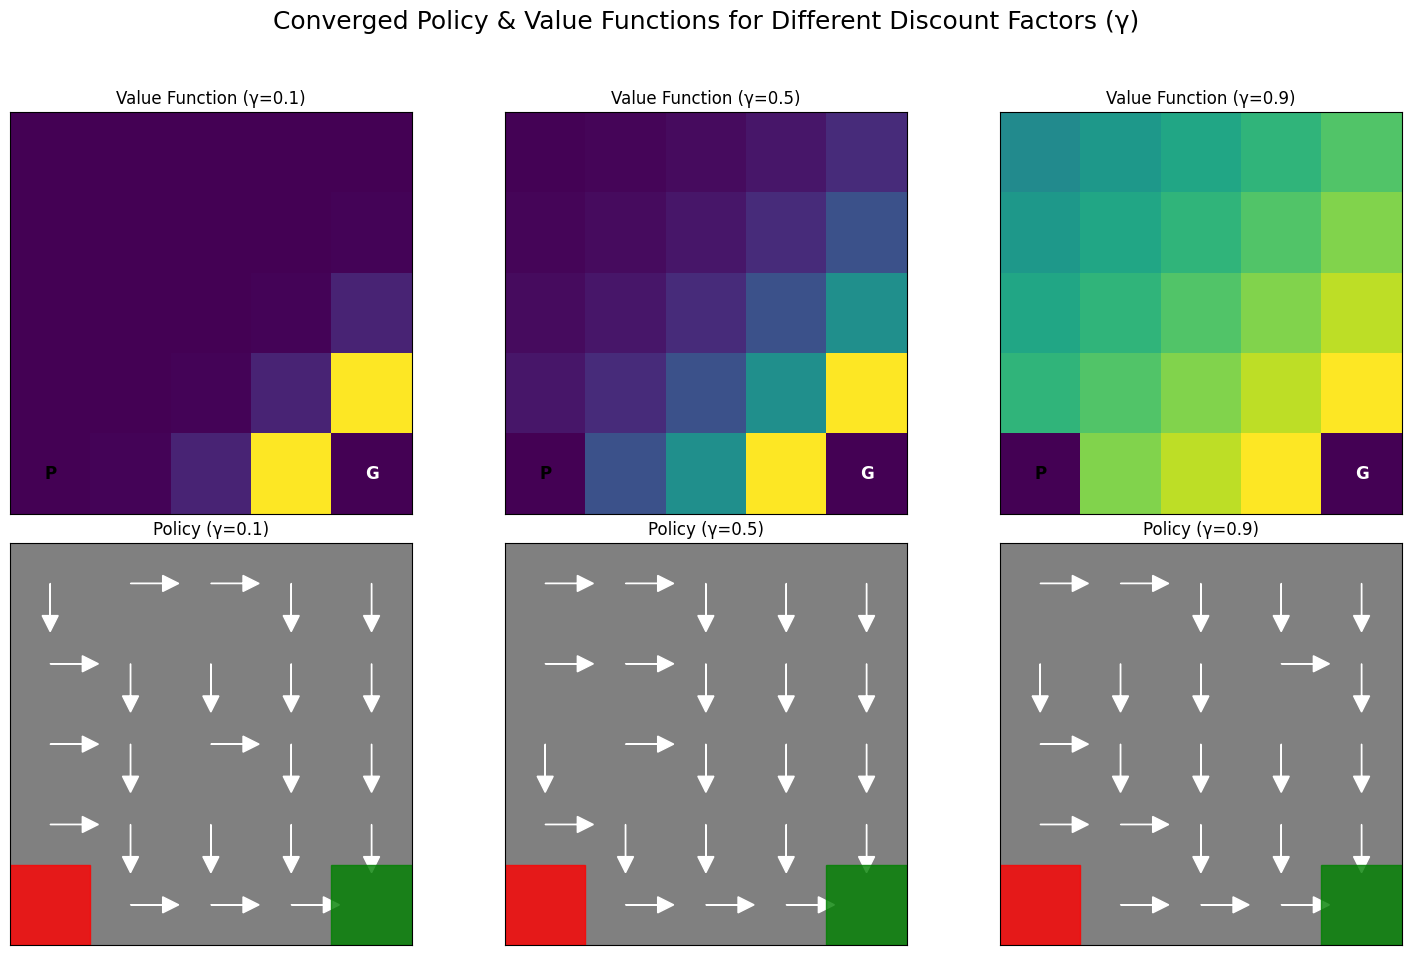


--- Running simulations for Part 3: Varying Epsilon ---


Training (γ=0.9, ε=0.5): 100%|██████████| 100000/100000 [00:12<00:00, 7725.98it/s]


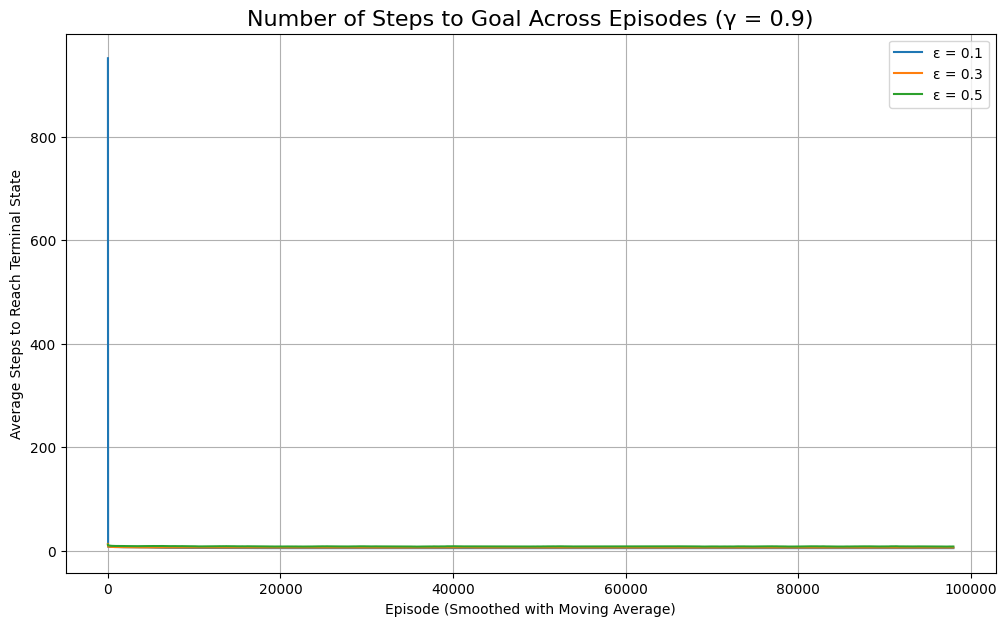

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from tqdm import tqdm # A library for creating progress bars

# --- Environment and Agent Setup ---

# Set a random seed for reproducibility
np.random.seed(42)

class GridWorld:
    """
    Defines the 5x5 Grid World environment.
    This class manages the game board, agent position, and rewards.
    """
    def __init__(self):
        self.size = 5
        self.agent_pos = [0, 0]
        self.goal_pos = [4, 4] # Goal state with reward +5
        self.pit_pos = [4, 0]  # Terminal state with reward -5

    def reset(self):
        """
        Resets the agent to a random starting position for a new episode.
        Ensures the agent does not start in a terminal state.
        """
        self.agent_pos = [np.random.randint(0, self.size), np.random.randint(0, self.size)]
        while list(self.agent_pos) == self.goal_pos or list(self.agent_pos) == self.pit_pos:
            self.agent_pos = [np.random.randint(0, self.size), np.random.randint(0, self.size)]
        return tuple(self.agent_pos)

    def step(self, action):
        """
        Performs an action and returns the new state, reward, and done flag.
        Actions are encoded as integers: 0=Up, 1=Down, 2=Left, 3=Right.
        """
        pos = list(self.agent_pos)
        next_pos = list(self.agent_pos)

        # Update position based on action
        if action == 0:    # Up
            next_pos[0] -= 1
        elif action == 1:  # Down
            next_pos[0] += 1
        elif action == 2:  # Left
            next_pos[1] -= 1
        elif action == 3:  # Right
            next_pos[1] += 1

        # Check for boundary collision
        if next_pos[0] < 0 or next_pos[0] >= self.size or \
           next_pos[1] < 0 or next_pos[1] >= self.size:
            return tuple(pos), -1, False # Reward -1, stay in place

        # Update the agent's position
        self.agent_pos = next_pos

        # Check for terminal states or standard moves
        if self.agent_pos == self.goal_pos:
            return tuple(self.agent_pos), 5, True   # Reward +5, episode done
        elif self.agent_pos == self.pit_pos:
            return tuple(self.agent_pos), -5, True  # Reward -5, episode done
        else:
            return tuple(self.agent_pos), 0, False  # Reward 0, continue

class QLearningAgent:
    """
    The agent that learns to navigate the environment using Q-Learning.
    This class manages the agent's "brain" (the Q-table) and its learning process.
    """
    def __init__(self, size, alpha, gamma, epsilon):
        self.actions = [0, 1, 2, 3] # Up, Down, Left, Right
        self.alpha = alpha     # Learning rate
        self.gamma = gamma     # Discount factor
        self.epsilon = epsilon # Exploration rate
        # The Q-table stores the expected value of taking an action in a state
        self.q_table = np.zeros((size, size, len(self.actions)))

    def choose_action(self, state):
        """
        Chooses an action using an epsilon-greedy policy.
        With probability epsilon, it explores a random action.
        Otherwise, it exploits the best-known action from the Q-table.
        """
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.actions) # Explore
        else:
            return np.argmax(self.q_table[state]) # Exploit

    def learn(self, state, action, reward, next_state, done):
        """
        Updates the Q-table using the Bellman equation for Q-Learning.
        """
        q_predict = self.q_table[state][action]
        # If the episode is done, the future value is just the final reward
        if done:
            q_target = reward
        # Otherwise, the future value is the reward + discounted max Q-value of the next state
        else:
            q_target = reward + self.gamma * np.max(self.q_table[next_state])

        # Update the Q-value for the state-action pair
        self.q_table[state][action] += self.alpha * (q_target - q_predict)

# --- Plotting Functions ---

def plot_policy_and_value(q_table, gamma, ax_v, ax_p):
    """
    Plots the value function as a heatmap and the policy as a set of arrows.
    """
    value_function = np.max(q_table, axis=2)
    policy = np.argmax(q_table, axis=2)

    # Plot 1: Value Function Heatmap
    ax_v.imshow(value_function, cmap='viridis')
    ax_v.set_title(f'Value Function (γ={gamma})')
    ax_v.set_xticks([]), ax_v.set_yticks([])
    ax_v.text(4, 4, 'G', ha='center', va='center', color='white', weight='bold', fontsize=12)
    ax_v.text(0, 4, 'P', ha='center', va='center', color='black', weight='bold', fontsize=12)

    # Plot 2: Policy (Arrows)
    ax_p.set_title(f'Policy (γ={gamma})')
    # Create a background and overlay arrows
    ax_p.imshow(np.zeros(policy.shape), cmap='gray', vmin=-1, vmax=1)

    # Define mapping from action index to (dy, dx) arrow vector
    action_map = {0: (-1, 0), 1: (1, 0), 2: (0, -1), 3: (0, 1)} # (row_change, col_change)
    for r in range(policy.shape[0]):
        for c in range(policy.shape[1]):
            if (r, c) != (4, 4) and (r, c) != (4, 0): # No arrows on terminal states
                dy, dx = action_map[policy[r, c]]
                # Plot an arrow in the middle of the cell
                if dx != 0 or dy != 0:
                    ax_p.arrow(c, r, dx*0.4, dy*0.4, head_width=0.2, head_length=0.2, fc='white', ec='white')

    # Mark Goal (G) and Pit (P) with colored squares for clarity
    goal_patch = mpatches.Rectangle((3.5, 3.5), 1, 1, color='green', alpha=0.8)
    pit_patch = mpatches.Rectangle((-0.5, 3.5), 1, 1, color='red', alpha=0.8)
    ax_p.add_patch(goal_patch)
    ax_p.add_patch(pit_patch)
    ax_p.set_xticks([]), ax_p.set_yticks([])
    ax_p.set_ylim(4.5, -0.5) # Invert y-axis to match matrix indexing
    ax_p.set_xlim(-0.5, 4.5)

# --- Main Simulation Logic ---

def run_simulation(env, agent, episodes):
    """
    Runs the main training loop for a specified number of episodes.
    Returns a list of the number of steps taken in each episode.
    """
    steps_per_episode = []
    # Use tqdm for a progress bar during training
    for _ in tqdm(range(episodes), desc=f"Training (γ={agent.gamma}, ε={agent.epsilon})"):
        state = env.reset()
        done = False
        steps = 0
        while not done:
            action = agent.choose_action(state)
            next_state, reward, done = env.step(action)
            agent.learn(state, action, reward, next_state, done)
            state = next_state
            steps += 1
        steps_per_episode.append(steps)
    return steps_per_episode

# --- Part 1 & 2: Varying Gamma (Discount Factor) ---
print("--- Running simulations for Part 1 & 2: Varying Gamma ---")
gamma_values = [0.1, 0.5, 0.9]
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Converged Policy & Value Functions for Different Discount Factors (γ)', fontsize=18)

for i, gamma in enumerate(gamma_values):
    env = GridWorld()
    # Epsilon = 0.1 and Alpha = 0.1 as specified
    agent = QLearningAgent(size=5, alpha=0.1, gamma=gamma, epsilon=0.1)
    run_simulation(env, agent, episodes=100000)
    plot_policy_and_value(agent.q_table, gamma, axes[0, i], axes[1, i])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# --- Part 3: Varying Epsilon (Exploration Rate) ---
print("\n--- Running simulations for Part 3: Varying Epsilon ---")
epsilon_values = [0.1, 0.3, 0.5]
gamma_fixed = 0.9 # Gamma = 0.9 as specified
plt.figure(figsize=(12, 7))

for epsilon in epsilon_values:
    env = GridWorld()
    # Alpha = 0.1 as specified
    agent = QLearningAgent(size=5, alpha=0.1, gamma=gamma_fixed, epsilon=epsilon)
    steps_data = run_simulation(env, agent, episodes=100000)

    # Smooth the noisy step data with a moving average to see the learning trend
    window_size = 2000
    moving_avg = np.convolve(steps_data, np.ones(window_size)/window_size, mode='valid')
    plt.plot(moving_avg, label=f'ε = {epsilon}')

plt.title(f'Number of Steps to Goal Across Episodes (γ = {gamma_fixed})', fontsize=16)
plt.xlabel('Episode (Smoothed with Moving Average)')
plt.ylabel('Average Steps to Reach Terminal State')
plt.legend()
plt.grid(True)
plt.show()

--- Running simulations for Part 1 & 2: Varying Gamma ---


Training (γ=0.9, ε=0.1): 100%|██████████| 100000/100000 [00:06<00:00, 15800.18it/s]


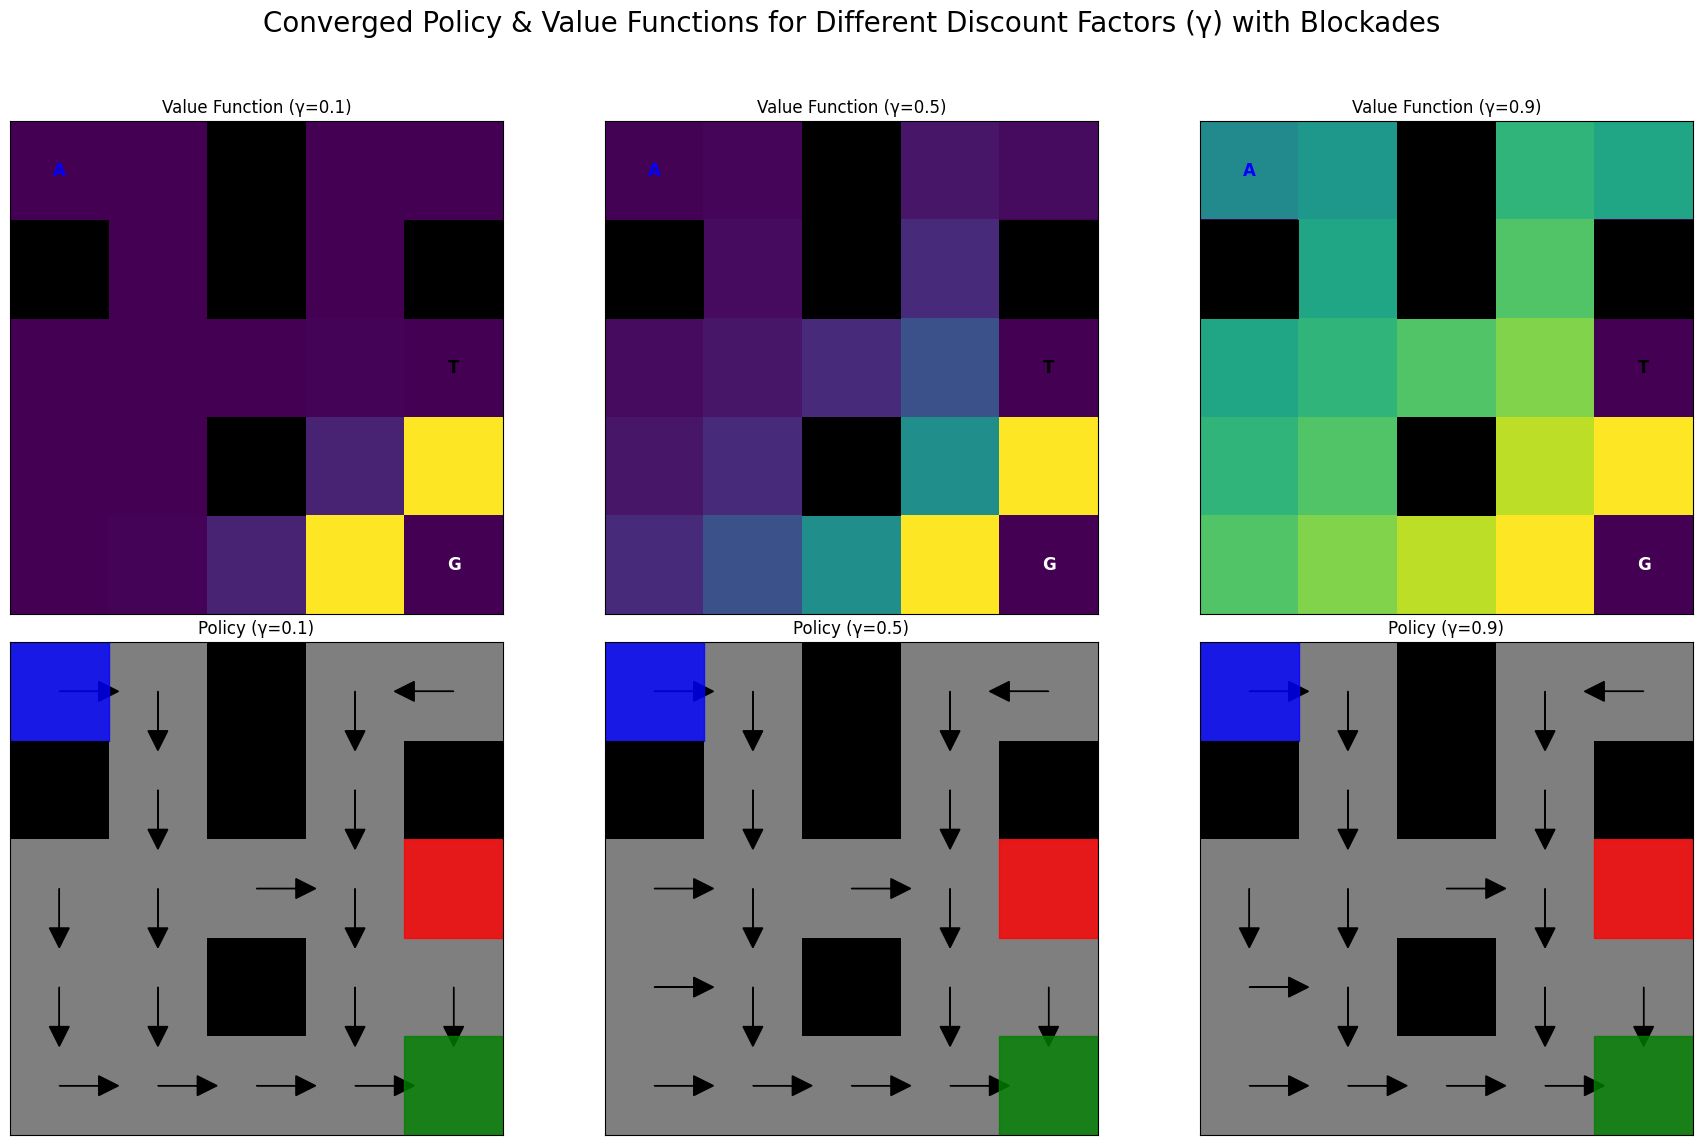


--- Running simulations for Part 3: Varying Epsilon ---


Training (γ=0.9, ε=0.5): 100%|██████████| 100000/100000 [00:14<00:00, 6733.73it/s]


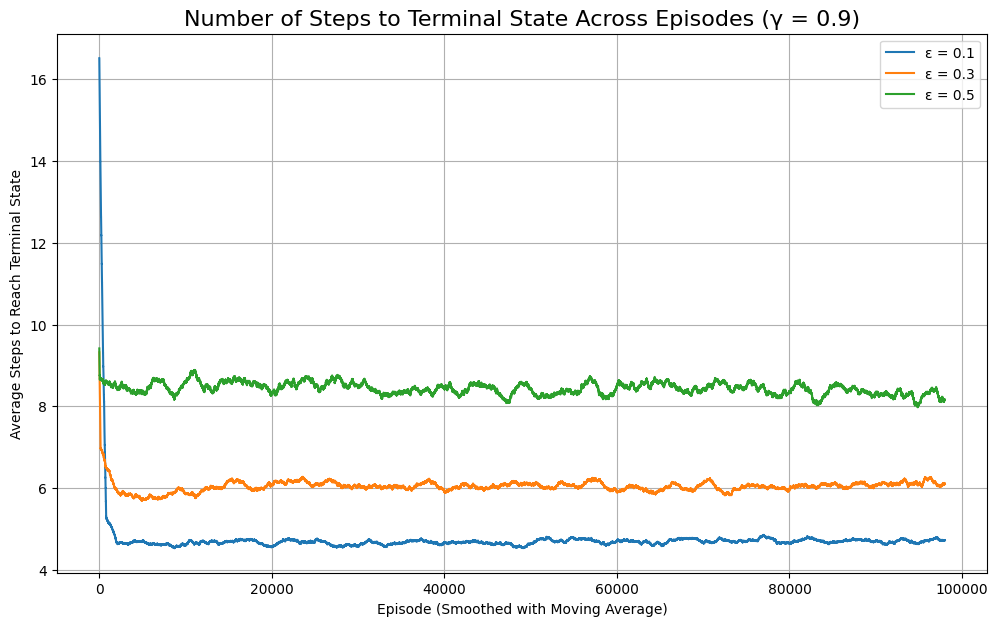

In [9]:

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from tqdm import tqdm # A library for creating progress bars

# --- Environment and Agent Setup ---

# Set a random seed for reproducibility
np.random.seed(42)

class GridWorld:
    """
    Defines the 5x5 Grid World environment with blockades.
    This class manages the game board, agent position, and rewards.
    """
    def __init__(self):
        self.size = 5
        self.agent_pos = [0, 0] # Agent starts at [0,0] (top-left 'A' in image)
        self.goal_pos = [4, 4]  # Goal state with reward +5 (bottom-right 'G' in image)
        self.pit_pos = [2, 4]   # Terminal state with reward -5 (middle-right 'T' in image)

        # Blockade positions as shown in the image (black squares)
        # Note: image coordinates are 1-indexed, array coordinates are 0-indexed
        self.blockade_pos = [
            [1, 0], [0, 2], [1, 2], [1, 4], [3, 2]
        ]

    def reset(self):
        """
        Resets the agent to a random starting position for a new episode.
        Ensures the agent does not start in a terminal state or on a blockade.
        """
        while True:
            self.agent_pos = [np.random.randint(0, self.size), np.random.randint(0, self.size)]
            # Ensure start is not a terminal state or a blockade
            if (list(self.agent_pos) != self.goal_pos and
                list(self.agent_pos) != self.pit_pos and
                list(self.agent_pos) not in self.blockade_pos):
                break
        return tuple(self.agent_pos)

    def step(self, action):
        """
        Performs an action and returns the new state, reward, and done flag.
        Actions are encoded as integers: 0=Up, 1=Down, 2=Left, 3=Right.
        """
        pos = list(self.agent_pos)
        next_pos = list(self.agent_pos)

        # Update position based on action
        if action == 0:    # Up
            next_pos[0] -= 1
        elif action == 1:  # Down
            next_pos[0] += 1
        elif action == 2:  # Left
            next_pos[1] -= 1
        elif action == 3:  # Right
            next_pos[1] += 1

        # Check for boundary collision OR blockade collision
        if next_pos[0] < 0 or next_pos[0] >= self.size or \
           next_pos[1] < 0 or next_pos[1] >= self.size or \
           list(next_pos) in self.blockade_pos: # Added blockade check
            return tuple(pos), -1, False # Reward -1, stay in place

        # Update the agent's position
        self.agent_pos = next_pos

        # Check for terminal states or standard moves
        if self.agent_pos == self.goal_pos:
            return tuple(self.agent_pos), 5, True   # Reward +5, episode done
        elif self.agent_pos == self.pit_pos:
            return tuple(self.agent_pos), -5, True  # Reward -5, episode done
        else:
            return tuple(self.agent_pos), 0, False  # Reward 0, continue

class QLearningAgent:
    """
    The agent that learns to navigate the environment using Q-Learning.
    This class manages the agent's "brain" (the Q-table) and its learning process.
    """
    def __init__(self, size, alpha, gamma, epsilon):
        self.actions = [0, 1, 2, 3] # Up, Down, Left, Right
        self.alpha = alpha     # Learning rate
        self.gamma = gamma     # Discount factor
        self.epsilon = epsilon # Exploration rate
        # The Q-table stores the expected value of taking an action in a state
        self.q_table = np.zeros((size, size, len(self.actions)))

    def choose_action(self, state):
        """
        Chooses an action using an epsilon-greedy policy.
        With probability epsilon, it explores a random action.
        Otherwise, it exploits the best-known action from the Q-table.
        """
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.actions) # Explore
        else:
            return np.argmax(self.q_table[state]) # Exploit

    def learn(self, state, action, reward, next_state, done):
        """
        Updates the Q-table using the Bellman equation for Q-Learning.
        """
        q_predict = self.q_table[state][action]
        # If the episode is done, the future value is just the final reward
        if done:
            q_target = reward
        # Otherwise, the future value is the reward + discounted max Q-value of the next state
        else:
            q_target = reward + self.gamma * np.max(self.q_table[next_state])

        # Update the Q-value for the state-action pair
        self.q_table[state][action] += self.alpha * (q_target - q_predict)

# --- Plotting Functions ---

def plot_policy_and_value(q_table, gamma, ax_v, ax_p, env):
    """
    Plots the value function as a heatmap and the policy as a set of arrows,
    including visual representation of blockades.
    """
    value_function = np.max(q_table, axis=2)
    policy = np.argmax(q_table, axis=2)

    # Plot 1: Value Function Heatmap
    ax_v.imshow(value_function, cmap='viridis')
    ax_v.set_title(f'Value Function (γ={gamma})')
    ax_v.set_xticks([]), ax_v.set_yticks([])
    ax_v.text(env.goal_pos[1], env.goal_pos[0], 'G', ha='center', va='center', color='white', weight='bold', fontsize=12)
    ax_v.text(env.pit_pos[1], env.pit_pos[0], 'T', ha='center', va='center', color='black', weight='bold', fontsize=12)
    ax_v.text(0, 0, 'A', ha='center', va='center', color='blue', weight='bold', fontsize=12) # Mark start (A)

    # Plot blockades on value function
    for r, c in env.blockade_pos:
        ax_v.add_patch(mpatches.Rectangle((c - 0.5, r - 0.5), 1, 1, facecolor='black', edgecolor='black', lw=0))


    # Plot 2: Policy (Arrows)
    ax_p.set_title(f'Policy (γ={gamma})')
    # Create a white background
    ax_p.imshow(np.zeros(policy.shape), cmap='gray_r', vmin=-1, vmax=1) # Use gray_r for white background

    # Define mapping from action index to (dy, dx) arrow vector
    action_map = {0: (-1, 0), 1: (1, 0), 2: (0, -1), 3: (0, 1)} # (row_change, col_change)
    for r in range(policy.shape[0]):
        for c in range(policy.shape[1]):
            # No arrows on terminal states or blockades
            if ([r, c] != env.goal_pos and
                [r, c] != env.pit_pos and
                [r, c] not in env.blockade_pos):
                dy, dx = action_map[policy[r, c]]
                # Plot an arrow in the middle of the cell
                if dx != 0 or dy != 0:
                    ax_p.arrow(c, r, dx*0.4, dy*0.4, head_width=0.2, head_length=0.2, fc='black', ec='black') # Arrows in black

    # Mark Goal (G) and Pit (T) with colored squares
    ax_p.add_patch(mpatches.Rectangle((env.goal_pos[1] - 0.5, env.goal_pos[0] - 0.5), 1, 1, facecolor='green', edgecolor='green', alpha=0.8))
    ax_p.add_patch(mpatches.Rectangle((env.pit_pos[1] - 0.5, env.pit_pos[0] - 0.5), 1, 1, facecolor='red', edgecolor='red', alpha=0.8))
    ax_p.add_patch(mpatches.Rectangle((-0.5, -0.5), 1, 1, facecolor='blue', edgecolor='blue', alpha=0.8)) # Mark starting A

    # Plot blockades as black squares
    for r, c in env.blockade_pos:
        ax_p.add_patch(mpatches.Rectangle((c - 0.5, r - 0.5), 1, 1, facecolor='black', edgecolor='black', lw=0))

    ax_p.set_xticks([]), ax_p.set_yticks([])
    ax_p.set_ylim(env.size - 0.5, -0.5) # Invert y-axis to match matrix indexing
    ax_p.set_xlim(-0.5, env.size - 0.5)

# --- Main Simulation Logic ---

def run_simulation(env, agent, episodes):
    """
    Runs the main training loop for a specified number of episodes.
    Returns a list of the number of steps taken in each episode.
    """
    steps_per_episode = []
    # Use tqdm for a progress bar during training
    for _ in tqdm(range(episodes), desc=f"Training (γ={agent.gamma}, ε={agent.epsilon})"):
        state = env.reset()
        done = False
        steps = 0
        # Limit steps per episode to prevent infinite loops in bad policies
        for step_limit in range(env.size * env.size * 2): # Max steps to 50 for a 5x5 grid
            action = agent.choose_action(state)
            next_state, reward, done = env.step(action)
            agent.learn(state, action, reward, next_state, done)
            state = next_state
            steps += 1
            if done:
                break
        steps_per_episode.append(steps)
    return steps_per_episode

# --- Part 1 & 2: Varying Gamma (Discount Factor) ---
print("--- Running simulations for Part 1 & 2: Varying Gamma ---")
gamma_values = [0.1, 0.5, 0.9]
fig, axes = plt.subplots(2, 3, figsize=(18, 12)) # Adjusted figure size for better readability
fig.suptitle('Converged Policy & Value Functions for Different Discount Factors (γ) with Blockades', fontsize=20)

for i, gamma in enumerate(gamma_values):
    env = GridWorld()
    # Epsilon = 0.1 and Alpha = 0.1 as specified
    agent = QLearningAgent(size=env.size, alpha=0.1, gamma=gamma, epsilon=0.1)
    run_simulation(env, agent, episodes=100000)
    plot_policy_and_value(agent.q_table, gamma, axes[0, i], axes[1, i], env)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# --- Part 3: Varying Epsilon (Exploration Rate) ---
print("\n--- Running simulations for Part 3: Varying Epsilon ---")
epsilon_values = [0.1, 0.3, 0.5]
gamma_fixed = 0.9 # Gamma = 0.9 as specified
plt.figure(figsize=(12, 7))

for epsilon in epsilon_values:
    env = GridWorld()
    # Alpha = 0.1 as specified
    agent = QLearningAgent(size=env.size, alpha=0.1, gamma=gamma_fixed, epsilon=epsilon)
    steps_data = run_simulation(env, agent, episodes=100000)

    # Smooth the noisy step data with a moving average to see the learning trend
    window_size = 2000
    moving_avg = np.convolve(steps_data, np.ones(window_size)/window_size, mode='valid')
    plt.plot(moving_avg, label=f'ε = {epsilon}')

plt.title(f'Number of Steps to Terminal State Across Episodes (γ = {gamma_fixed})', fontsize=16)
plt.xlabel('Episode (Smoothed with Moving Average)')
plt.ylabel('Average Steps to Reach Terminal State')
plt.legend()
plt.grid(True)
plt.show()


--- Running simulations for Part 1 & 2: Varying Gamma ---


Training (γ=0.9, ε=0.1): 100%|██████████| 100000/100000 [00:06<00:00, 15017.64it/s]


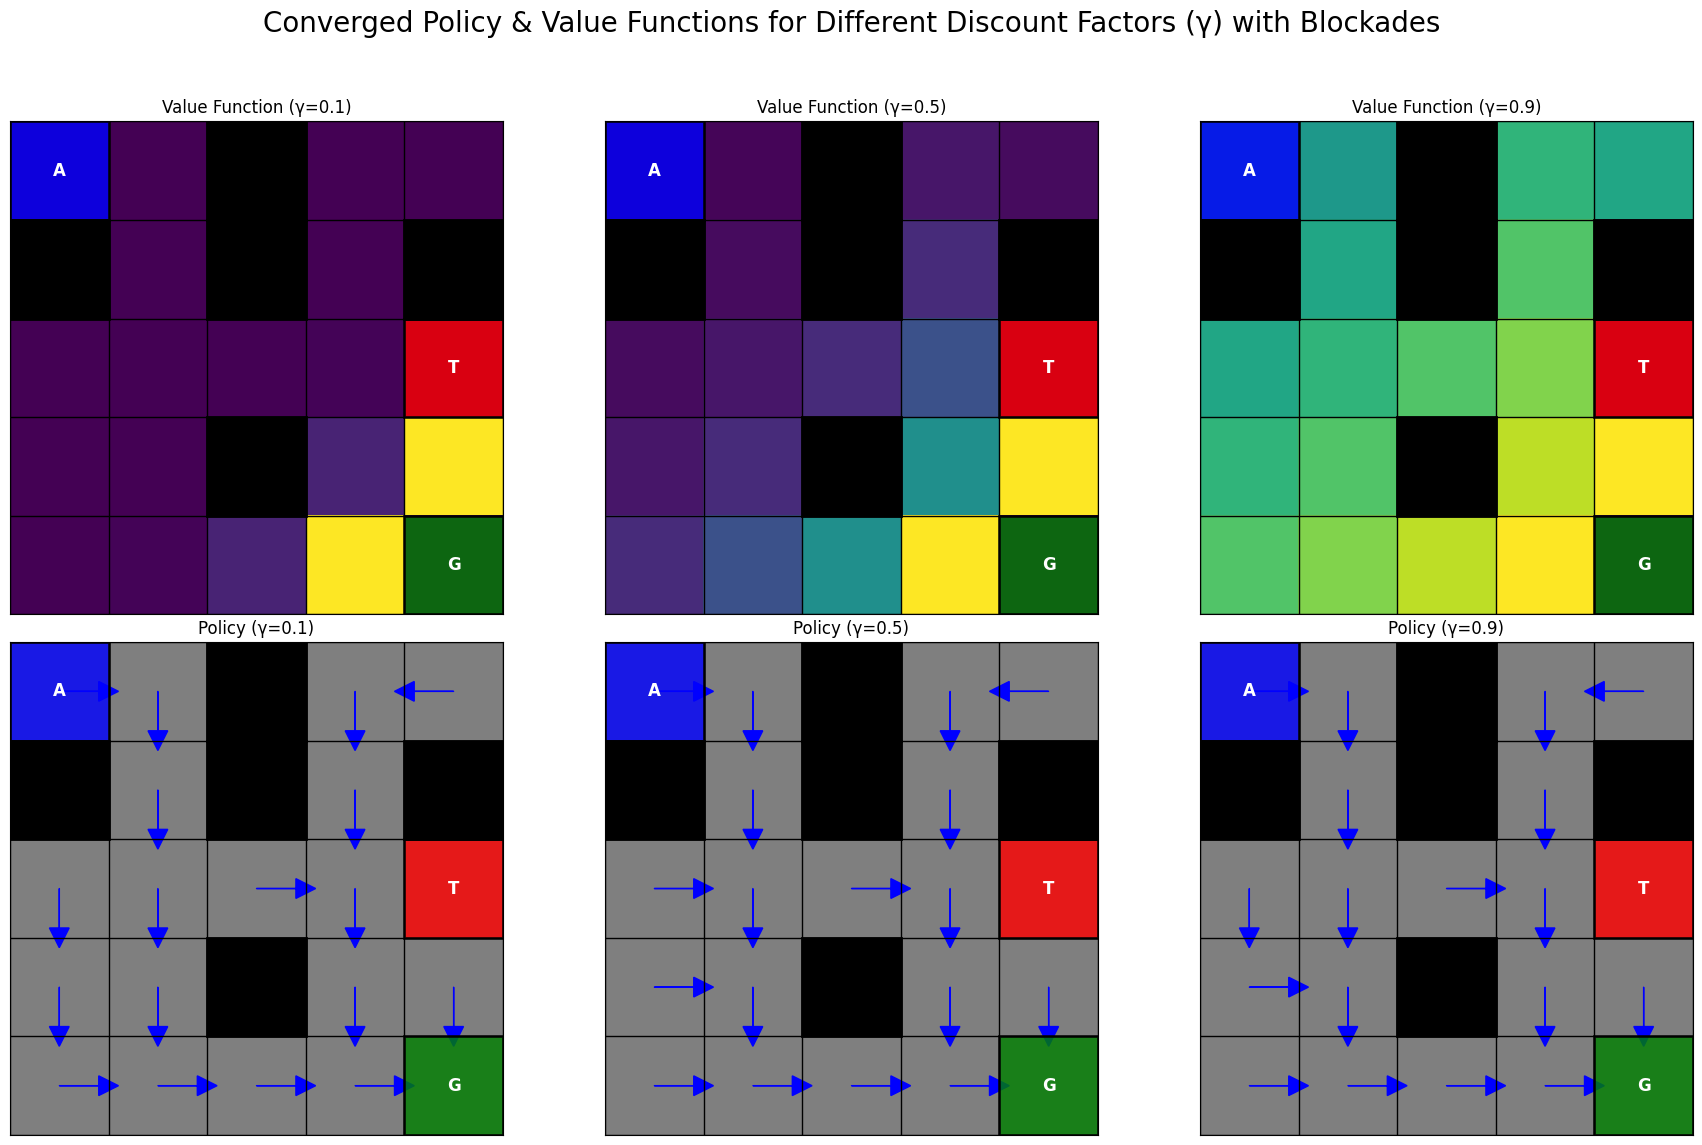


--- Running simulations for Part 3: Varying Epsilon ---


Training (γ=0.9, ε=0.5): 100%|██████████| 100000/100000 [00:14<00:00, 7121.89it/s]


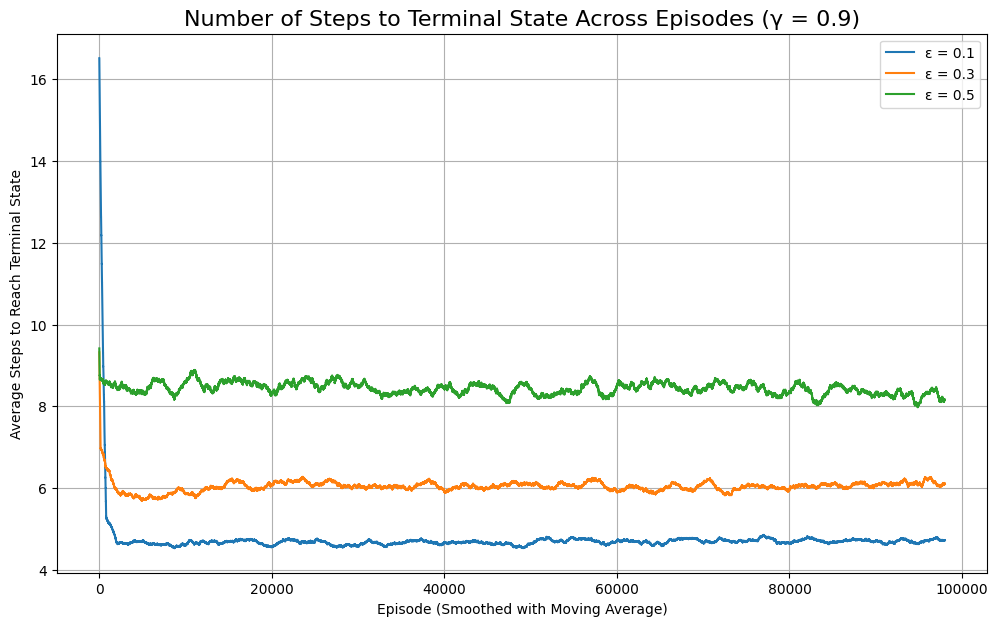

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from tqdm import tqdm # A library for creating progress bars

# --- Environment and Agent Setup ---

# Set a random seed for reproducibility
np.random.seed(42)

class GridWorld:
    """
    Defines the 5x5 Grid World environment with blockades.
    This class manages the game board, agent position, and rewards.
    """
    def __init__(self):
        self.size = 5
        self.start_pos = [0, 0] # Agent starts at [0,0] (top-left 'A' in image)
        self.agent_pos = list(self.start_pos) # Current agent position
        self.goal_pos = [4, 4]  # Goal state with reward +5 (bottom-right 'G' in image)
        self.pit_pos = [2, 4]   # Terminal state with reward -5 (middle-right 'T' in image)

        # Blockade positions as shown in the image (black squares)
        # Note: image coordinates are 1-indexed, array coordinates are 0-indexed
        self.blockade_pos = [
            [1, 0], [0, 2], [1, 2], [1, 4], [3, 2]
        ]

    def reset(self):
        """
        Resets the agent to a random starting position for a new episode.
        Ensures the agent does not start in a terminal state or on a blockade.
        """
        while True:
            self.agent_pos = [np.random.randint(0, self.size), np.random.randint(0, self.size)]
            # Ensure start is not a terminal state or a blockade
            if (list(self.agent_pos) != self.goal_pos and
                list(self.agent_pos) != self.pit_pos and
                list(self.agent_pos) not in self.blockade_pos):
                break
        # For consistent 'A' marker on plots, always start from start_pos
        # Comment the above while loop and uncomment the line below to always start from [0,0]
        # self.agent_pos = list(self.start_pos)
        return tuple(self.agent_pos)

    def step(self, action):
        """
        Performs an action and returns the new state, reward, and done flag.
        Actions are encoded as integers: 0=Up, 1=Down, 2=Left, 3=Right.
        """
        pos = list(self.agent_pos)
        next_pos = list(self.agent_pos)

        # Update position based on action
        if action == 0:    # Up
            next_pos[0] -= 1
        elif action == 1:  # Down
            next_pos[0] += 1
        elif action == 2:  # Left
            next_pos[1] -= 1
        elif action == 3:  # Right
            next_pos[1] += 1

        # Check for boundary collision OR blockade collision
        if next_pos[0] < 0 or next_pos[0] >= self.size or \
           next_pos[1] < 0 or next_pos[1] >= self.size or \
           list(next_pos) in self.blockade_pos: # Added blockade check
            return tuple(pos), -1, False # Reward -1, stay in place

        # Update the agent's position
        self.agent_pos = next_pos

        # Check for terminal states or standard moves
        if self.agent_pos == self.goal_pos:
            return tuple(self.agent_pos), 5, True   # Reward +5, episode done
        elif self.agent_pos == self.pit_pos:
            return tuple(self.agent_pos), -5, True  # Reward -5, episode done
        else:
            return tuple(self.agent_pos), 0, False  # Reward 0, continue

class QLearningAgent:
    """
    The agent that learns to navigate the environment using Q-Learning.
    This class manages the agent's "brain" (the Q-table) and its learning process.
    """
    def __init__(self, size, alpha, gamma, epsilon):
        self.actions = [0, 1, 2, 3] # Up, Down, Left, Right
        self.alpha = alpha     # Learning rate
        self.gamma = gamma     # Discount factor
        self.epsilon = epsilon # Exploration rate
        # The Q-table stores the expected value of taking an action in a state
        self.q_table = np.zeros((size, size, len(self.actions)))

    def choose_action(self, state):
        """
        Chooses an action using an epsilon-greedy policy.
        With probability epsilon, it explores a random action.
        Otherwise, it exploits the best-known action from the Q-table.
        """
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.actions) # Explore
        else:
            return np.argmax(self.q_table[state]) # Exploit

    def learn(self, state, action, reward, next_state, done):
        """
        Updates the Q-table using the Bellman equation for Q-Learning.
        """
        q_predict = self.q_table[state][action]
        # If the episode is done, the future value is just the final reward
        if done:
            q_target = reward
        # Otherwise, the future value is the reward + discounted max Q-value of the next state
        else:
            q_target = reward + self.gamma * np.max(self.q_table[next_state])

        # Update the Q-value for the state-action pair
        self.q_table[state][action] += self.alpha * (q_target - q_predict)

# --- Plotting Functions ---

def plot_policy_and_value(q_table, gamma, ax_v, ax_p, env):
    """
    Plots the value function as a heatmap and the policy as a set of arrows,
    including visual representation of blockades and grid outlines.
    """
    value_function = np.max(q_table, axis=2)
    policy = np.argmax(q_table, axis=2)

    # Plot 1: Value Function Heatmap
    ax_v.imshow(value_function, cmap='viridis')
    ax_v.set_title(f'Value Function (γ={gamma})')
    ax_v.set_xticks([]), ax_v.set_yticks([])

    # Plot grid lines
    for x in range(env.size + 1):
        ax_v.axhline(x - 0.5, color='black', lw=1)
        ax_v.axvline(x - 0.5, color='black', lw=1)

    # Mark Goal (G), Pit (T), and Start (A)
    ax_v.add_patch(mpatches.Rectangle((env.goal_pos[1] - 0.5, env.goal_pos[0] - 0.5), 1, 1, facecolor='green', edgecolor='black', lw=2, alpha=0.8))
    ax_v.text(env.goal_pos[1], env.goal_pos[0], 'G', ha='center', va='center', color='white', weight='bold', fontsize=12)

    ax_v.add_patch(mpatches.Rectangle((env.pit_pos[1] - 0.5, env.pit_pos[0] - 0.5), 1, 1, facecolor='red', edgecolor='black', lw=2, alpha=0.8))
    ax_v.text(env.pit_pos[1], env.pit_pos[0], 'T', ha='center', va='center', color='white', weight='bold', fontsize=12)

    ax_v.add_patch(mpatches.Rectangle((env.start_pos[1] - 0.5, env.start_pos[0] - 0.5), 1, 1, facecolor='blue', edgecolor='black', lw=2, alpha=0.8))
    ax_v.text(env.start_pos[1], env.start_pos[0], 'A', ha='center', va='center', color='white', weight='bold', fontsize=12)

    # Plot blockades on value function
    for r, c in env.blockade_pos:
        ax_v.add_patch(mpatches.Rectangle((c - 0.5, r - 0.5), 1, 1, facecolor='black', edgecolor='black', lw=2))


    # Plot 2: Policy (Arrows)
    ax_p.set_title(f'Policy (γ={gamma})')
    # Create a white background
    ax_p.imshow(np.zeros(policy.shape), cmap='gray_r', vmin=-1, vmax=1) # Use gray_r for white background

    # Plot grid lines
    for x in range(env.size + 1):
        ax_p.axhline(x - 0.5, color='black', lw=1)
        ax_p.axvline(x - 0.5, color='black', lw=1)

    # Define mapping from action index to (dy, dx) arrow vector
    action_map = {0: (-1, 0), 1: (1, 0), 2: (0, -1), 3: (0, 1)} # (row_change, col_change)
    for r in range(policy.shape[0]):
        for c in range(policy.shape[1]):
            # No arrows on terminal states or blockades
            if ([r, c] != env.goal_pos and
                [r, c] != env.pit_pos and
                [r, c] not in env.blockade_pos):
                dy, dx = action_map[policy[r, c]]
                # Plot an arrow in the middle of the cell, colored blue
                if dx != 0 or dy != 0:
                    ax_p.arrow(c, r, dx*0.4, dy*0.4, head_width=0.2, head_length=0.2, fc='blue', ec='blue')

    # Mark Goal (G) and Pit (T) with colored squares
    ax_p.add_patch(mpatches.Rectangle((env.goal_pos[1] - 0.5, env.goal_pos[0] - 0.5), 1, 1, facecolor='green', edgecolor='black', lw=2, alpha=0.8))
    ax_p.text(env.goal_pos[1], env.goal_pos[0], 'G', ha='center', va='center', color='white', weight='bold', fontsize=12)

    ax_p.add_patch(mpatches.Rectangle((env.pit_pos[1] - 0.5, env.pit_pos[0] - 0.5), 1, 1, facecolor='red', edgecolor='black', lw=2, alpha=0.8))
    ax_p.text(env.pit_pos[1], env.pit_pos[0], 'T', ha='center', va='center', color='white', weight='bold', fontsize=12)

    ax_p.add_patch(mpatches.Rectangle((env.start_pos[1] - 0.5, env.start_pos[0] - 0.5), 1, 1, facecolor='blue', edgecolor='black', lw=2, alpha=0.8))
    ax_p.text(env.start_pos[1], env.start_pos[0], 'A', ha='center', va='center', color='white', weight='bold', fontsize=12)


    # Plot blockades as black squares
    for r, c in env.blockade_pos:
        ax_p.add_patch(mpatches.Rectangle((c - 0.5, r - 0.5), 1, 1, facecolor='black', edgecolor='black', lw=2))

    ax_p.set_xticks([]), ax_p.set_yticks([])
    ax_p.set_ylim(env.size - 0.5, -0.5) # Invert y-axis to match matrix indexing
    ax_p.set_xlim(-0.5, env.size - 0.5)

# --- Main Simulation Logic ---

def run_simulation(env, agent, episodes):
    """
    Runs the main training loop for a specified number of episodes.
    Returns a list of the number of steps taken in each episode.
    """
    steps_per_episode = []
    # Use tqdm for a progress bar during training
    for _ in tqdm(range(episodes), desc=f"Training (γ={agent.gamma}, ε={agent.epsilon})"):
        state = env.reset()
        done = False
        steps = 0
        # Limit steps per episode to prevent infinite loops in bad policies
        for step_limit in range(env.size * env.size * 2): # Max steps to 50 for a 5x5 grid
            action = agent.choose_action(state)
            next_state, reward, done = env.step(action)
            agent.learn(state, action, reward, next_state, done)
            state = next_state
            steps += 1
            if done:
                break
        steps_per_episode.append(steps)
    return steps_per_episode

# --- Part 1 & 2: Varying Gamma (Discount Factor) ---
print("--- Running simulations for Part 1 & 2: Varying Gamma ---")
gamma_values = [0.1, 0.5, 0.9]
fig, axes = plt.subplots(2, 3, figsize=(18, 12)) # Adjusted figure size for better readability
fig.suptitle('Converged Policy & Value Functions for Different Discount Factors (γ) with Blockades', fontsize=20)

for i, gamma in enumerate(gamma_values):
    env = GridWorld()
    # Epsilon = 0.1 and Alpha = 0.1 as specified
    agent = QLearningAgent(size=env.size, alpha=0.1, gamma=gamma, epsilon=0.1)
    run_simulation(env, agent, episodes=100000)
    plot_policy_and_value(agent.q_table, gamma, axes[0, i], axes[1, i], env)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# --- Part 3: Varying Epsilon (Exploration Rate) ---
print("\n--- Running simulations for Part 3: Varying Epsilon ---")
epsilon_values = [0.1, 0.3, 0.5]
gamma_fixed = 0.9 # Gamma = 0.9 as specified
plt.figure(figsize=(12, 7))

for epsilon in epsilon_values:
    env = GridWorld()
    # Alpha = 0.1 as specified
    agent = QLearningAgent(size=env.size, alpha=0.1, gamma=gamma_fixed, epsilon=epsilon)
    steps_data = run_simulation(env, agent, episodes=100000)

    # Smooth the noisy step data with a moving average to see the learning trend
    window_size = 2000
    moving_avg = np.convolve(steps_data, np.ones(window_size)/window_size, mode='valid')
    plt.plot(moving_avg, label=f'ε = {epsilon}')

plt.title(f'Number of Steps to Terminal State Across Episodes (γ = {gamma_fixed})', fontsize=16)
plt.xlabel('Episode (Smoothed with Moving Average)')
plt.ylabel('Average Steps to Reach Terminal State')
plt.legend()
plt.grid(True)
plt.show()